# The Continuous Thought Machine – Tutorial 03: Mazes [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SakanaAI/continuous-thought-machines/blob/main/examples/03_mazes.ipynb) [![arXiv](https://img.shields.io/badge/arXiv-2505.05522-b31b1b.svg)](https://arxiv.org/abs/2505.05522)

### Maze Solving

In Section 4 of the [technical report](https://arxiv.org/pdf/2505.05522), we showcase how a CTM can be used to solve 2D mazes. Typically in the literature, the task of solving a maze is described as a form of binary classification: by ensuring the output space matches the dimensions of the input space, a model can classify, for each pixel in the input image, if the pixel belongs to the path through the maze. While this approach has seen success, it excludes the need to think in a more natural fashion. We seek to design a more challenging task, where a more-human like solution is required.



### Solving Mazes the Hard Way

Instead of classifying if each pixel in the maze is or is not along the solution path, we instead constrain the output space, such that the model must output a plan: an entire trajectory of actions corresponding to the steps an agent must take to go from the start position to goal position. Specifically, for each internal tick of the CTM, the model produces a sequence of actions. These actions correspond to Left, Right, Up, Down and Wait (or no-op). We can then use a cross-entropy loss function which compares these actions produced by the CTM to the ground-truth trajectory required to solve the maze.

### Tutorial Overview

This tutorial will walk through how to train a CTM to solve mazes the hard way. It is structured as follows:
1) Setup
2) Data
3) Loss Function
4) Defining a Training Function
5) Initializing the CTM
6) Running the Training

### Setup

In addition to installing some dependencies, we also clone the CTM repo (assuming this tutorial is being ran in Colab), so that we can access the base CTM model.

In [ ]:
USE_COLAB = False

In [ ]:
import sys

if USE_COLAB:
    !git clone https://github.com/SakanaAI/continuous-thought-machines.git
    sys.path.append("./continuous-thought-machines")
else:
    sys.path.append("..")

In [ ]:
!pip install gdown
!pip install mediapy
!git clone https://github.com/SakanaAI/continuous-thought-machines.git


Download the training and test data

In [ ]:
!gdown "https://drive.google.com/uc?id=1Z8FFnZ7pZcu7DfoSyfy-ghWa08lgYl1V"
!unzip "small-mazes.zip"

Imports

In [4]:
import os
import torch
import torch.nn as nn
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from PIL import Image
import imageio
import mediapy
import re

#from models.ctm import ContinuousThoughtMachine as CTM
from ctms.data.custom_datasets import MazeImageFolder
from ctms.tasks.mazes.plotting import make_maze_gif
from ctms.tasks.image_classification.plotting import plot_neural_dynamics

In [5]:
import sys
import os

# Go up one directory level
sys.path.append('..')

# Now you can import
from models.ctm_attn import ContinuousThoughtMachineAttn as CTMA

In [6]:
%matplotlib inline

Set a seed for reproducibility

In [7]:
def set_seed(seed=42, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = deterministic
    torch.backends.cudnn.benchmark = False

In [8]:
set_seed(42)

### Data

The training (test) folder contains roughly 9000 (1000) images of mazes, at a resolution of 15x15. In these images, the red and green pixels correspond to the start and goal position respectively, while the blue pixels indicate the path through the maze. We will use these blue pixels to construct targets, and remove them from the images.

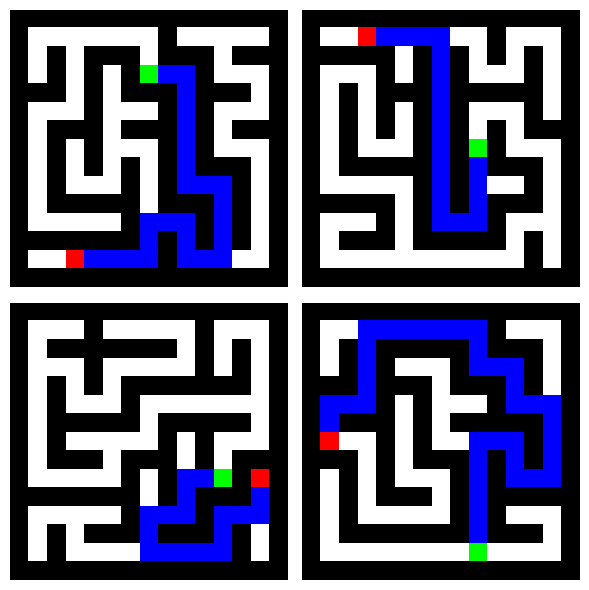

In [9]:
data_root = './small-mazes'
train_dir = f"{data_root}/train/0"
images = os.listdir(train_dir)[:4]

plt.figure(figsize=(6, 6))
for i, img_name in enumerate(images):
    img = Image.open(f"{data_root}/train/0/{img_name}")
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

To use these mazes, we have built a custom dataset `MazeImageFolder`. This dataset creates the input-target pairs corresponding to the unsolved mazes images and their solutions. For more details on how this dataset processes the images, please refer to its implementation [here](https://github.com/SakanaAI/continuous-thought-machines/blob/aecfb63ac42db7a20903ee27489ff71671669474/data/custom_datasets.py#L142C7-L142C22).

Note that the `MazeImageFolder` takes a `maze_route_length` argument. This parameter specifies the fixed length of action sequences that the CTM will generate at each internal tick. Since different mazes have solutions of varying lengths, all target sequences are padded with the integer 4 (corresponding to a wait or no operation) to ensure they match the specified `maze_route_length`.

In [10]:
train_data = MazeImageFolder(root=f'{data_root}/train/', which_set='train', maze_route_length=50)
test_data = MazeImageFolder(root=f'{data_root}/test/', which_set='test', maze_route_length=50)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0, drop_last=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers=1, drop_last=True)

Loading mazes:  33%|███▎      | 2977/9000 [00:02<00:04, 1348.05it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loading mazes:  84%|████████▍ | 7603/9000 [00:05<00:01, 1328.08it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Solving all mazes...


Loading mazes: 100%|██████████| 1000/1000 [00:00<00:00, 1383.39it/s]


Solving all mazes...


We can visualise what these inputs and targets look like.

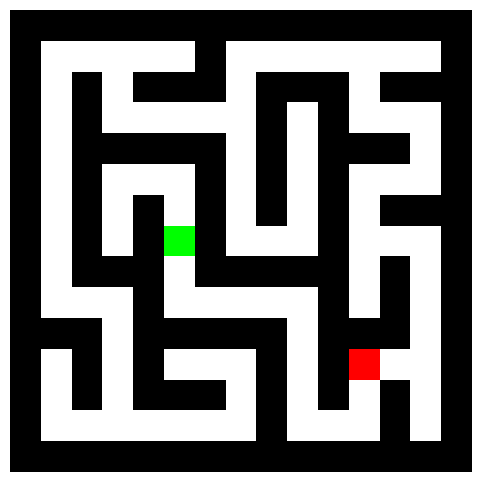

Target action sequence:
[1, 1, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [11]:
sample_inputs, sample_targets = next(iter(testloader))
sample_input, sample_target = sample_inputs[0], sample_targets[0]
sample_input = sample_input.permute(1, 2, 0).numpy()
plt.figure(figsize=(6, 6))
plt.imshow(np.clip(sample_input, 0, 1))
plt.axis('off')
plt.show()

print("Target action sequence:")
print(f"{sample_target.tolist()}")

As shown in the above output, the target is a sequence of integers, each corresponding to an action: 
  - 0: Up
  - 1: Down  
  - 2: Left
  - 3: Right
  - 4: No Operation / Padding

Note that the target sequence has been padded with 4s to achieve the desired length of `maze_route_length`.

Let's also plot the distribution of maze lengths. We can see that the mode of the distribution is 50, corresponding to us slicing trajectories beyond the `maze_route_length=50` action.

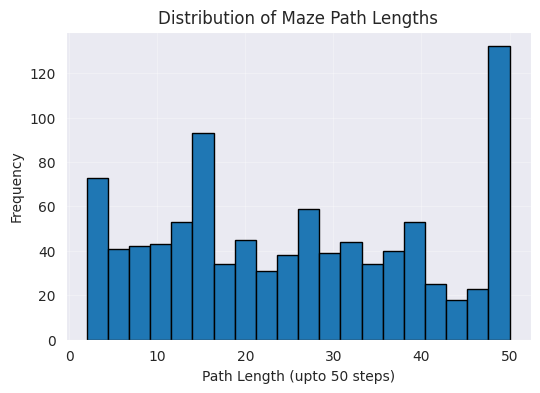

In [12]:
all_lengths = []
for _, targets in testloader:
    for target in targets:
        length = (target != 4).sum().item()
        all_lengths.append(length)

# Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(all_lengths, bins=20, edgecolor='black')
plt.title("Distribution of Maze Path Lengths")
plt.xlabel("Path Length (upto 50 steps)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

### Loss Function

Next, we define the loss function. We use the cross-entropy loss but there are two main points to highlight:

1) Although we compute the loss at all internal ticks, we only use include in the final loss the value at **two specific internal ticks**. These correspond to the internal tick which achieved the lowest cross-entropy loss of all internal ticks (`loss_index_1` below), and the internal tick at which the model has the highest certainty (`loss_index_2` below). Becaues these indices will vary across batch elements we define a `batch_indexer` which we can use for advanced indexing into the `losses` tensor which stores the loss at all internal ticks.

2) Our loss calculation uses an auto-extending cirriculum. Specifically, for each trajectory (recall the CTM produces an entire trajectory for every internal tick), we find the index of the first action that the CTM got wrong, and then **only include in our loss the trajectory up to and extending `cirriculum_lookahead` actions beyond this first incorrect action**. In this way, the CTM initially focuses on correctly predicting the first actions, and as it learns, it gets better at producing later and later actions.


In [13]:
def maze_loss(predictions, certainties, targets, cirriculum_lookahead=5, use_most_certain=True):
    """
    Computes the maze loss with auto-extending cirriculum.

    Predictions are of shape: (B, route_length, class, internal_ticks),
        where classes are in [0,1,2,3,4] for [Up, Down, Left, Right, Wait]
    Certainties are of shape: (B, 2, internal_ticks), 
        where the inside dimension (2) is [normalised_entropy, 1-normalised_entropy]
    Targets are of shape: [B, route_length]

    cirriculum_lookahead: how far to look ahead in the auto-cirriculum

    use_most_certain will select either the most certain point or the final point. For baselines,
        the final point proved the only usable option. 
    
    """
    # Predictions reshaped to: [B*route_length, 5, internal_ticks]
    predictions_reshaped = predictions.flatten(0,1)
    # Targets reshaped to: [B*route_length, internal_ticks]
    targets_reshaped = torch.repeat_interleave(targets.unsqueeze(-1), 
                                               predictions.size(-1), -1).flatten(0,1).long()
    
    # Losses are of shape [B, route_length, internal_ticks]
    losses = nn.CrossEntropyLoss(reduction='none')(predictions_reshaped, targets_reshaped)
    losses = losses.reshape(predictions[:,:,0].shape)
    
    # Below is the code for auto-cirriculum
    # Find where correct, and make sure to always push +5 beyond that
    iscorrects = (predictions.argmax(2) == targets.unsqueeze(-1)).cumsum(1)
    correct_mask = (iscorrects == torch.arange(1, iscorrects.size(1)+1, device=iscorrects.device).reshape(1, -1, 1))
    correct_mask[:,0,:] = 1
    upto_where = correct_mask.cumsum(1).argmax(1).max(-1)[0]+cirriculum_lookahead
    loss_mask = torch.zeros_like(losses)
    for bi in range(predictions.size(0)):
        loss_mask[bi, :upto_where[bi]] = 1

    # Reduce losses along route dimension
    # Will now be of shape [B, internal_ticks]
    losses = (losses * loss_mask).sum(1)/(loss_mask.sum(1))

    loss_index_1 = losses.argmin(dim=1)
    loss_index_2 = certainties[:,1].argmax(-1)
    if not use_most_certain:
        loss_index_2[:] = -1
    
    batch_indexer = torch.arange(predictions.size(0), device=predictions.device)
    loss_minimum_ce = losses[batch_indexer, loss_index_1]
    loss_selected = losses[batch_indexer, loss_index_2]

    loss = ((loss_minimum_ce + loss_selected)/2).mean()
    return loss, loss_index_2, upto_where.detach().cpu().numpy()

### Defining a Training Function

First, we define a helper function to update the training progress bar with key metrics:

Displayed Metrics:

- Train and Test Loss: The loss values during training and testing
- Train and Test Step Acc: The average accuracy of each action
- Train and Test Maze Acc: The average accuracy of the full trajectory predicted, measuring how many trajectories the CTM predicts perfectly
- Statistics on the internal ticks:
    - Average internal tick where the model has highest certainty
    - Standard deviation of these certainty peaks
    - Range (min ↔ max) of internal ticks where peak certainty occurs
    - The position upto which the loss is taken, on average


In [14]:
def make_pbar_desc(train_loss, train_accuracy_step, train_accuracy_maze, test_loss, test_accuracy_step, test_accuracy_maze, lr, where_most_certain, upto_where):
    """A helper function to create a description for the tqdm progress bar"""
    pbar_desc = (
        f"Train Loss={train_loss:0.3f}. "
        f"Train Step Acc={train_accuracy_step:0.3f}. "
        f"Train Maze Acc={train_accuracy_maze:0.3f}. "
        f"Test Loss={test_loss:0.3f}. "
        f"Test Step Acc={test_accuracy_step:0.3f}. "
        f"Test Maze Acc={test_accuracy_maze:0.3f}. "
        f"LR={lr:0.6f}. "
    )
    pbar_desc += (
        f"Where_certain={where_most_certain.float().mean().item():0.2f}"
        f"+-{where_most_certain.float().std().item():0.2f} "
        f"({where_most_certain.min().item():d}<->{where_most_certain.max().item():d}). "
        f"Upto={sum(upto_where) / len(upto_where):0.2f}."
    )
    return pbar_desc


In [15]:
def update_training_curve_plot(fig, ax1, ax2, train_losses, test_losses, train_accuracies_step, train_accuracies_maze, test_accuracies_step, test_accuracies_maze, steps):
    clear_output(wait=True)
    
    # Plot loss
    ax1.clear()
    ax1.plot(range(len(train_losses)), train_losses, 'b-', alpha=0.7, label=f'Train Loss: {train_losses[-1]:.3f}')
    ax1.plot(steps, test_losses, 'r-', marker='o', label=f'Test Loss: {test_losses[-1]:.3f}')
    ax1.set_title('Loss')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracy (step and maze)
    ax2.clear()
    ax2.plot(range(len(train_accuracies_step)), train_accuracies_step, 'b-', alpha=0.7, label=f'Train Step Acc: {train_accuracies_step[-1]:.3f}')
    ax2.plot(range(len(train_accuracies_maze)), train_accuracies_maze, 'g--', alpha=0.7, label=f'Train Maze Acc: {train_accuracies_maze[-1]:.3f}')
    ax2.plot(steps, test_accuracies_step, 'r-', marker='o', label=f'Test Step Acc: {test_accuracies_step[-1]:.3f}')
    ax2.plot(steps, test_accuracies_maze, color='orange', linestyle='--', marker='o', label=f'Test Maze Acc: {test_accuracies_maze[-1]:.3f}')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    display(fig)

In [16]:
def train(model, trainloader, testloader, device='cpu', training_iterations=10000, test_every=1000, checkpoint_every=10000, lr=1e-4, log_dir='./logs'):

    def get_latest_checkpoint(log_dir):
        files = [f for f in os.listdir(log_dir) if re.match(r'checkpoint_\d+\.pt', f)]
        return os.path.join(log_dir, max(files, key=lambda f: int(re.search(r'\d+', f).group()))) if files else None

    os.makedirs(log_dir, exist_ok=True)

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    if latest_checkpoint_path := get_latest_checkpoint(log_dir):
        checkpoint = torch.load(f'{latest_checkpoint_path}', weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'], strict=True)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        train_losses = checkpoint['train_losses']
        test_losses = checkpoint['test_losses']
        train_accuracies_step = checkpoint['train_accuracies_step']
        train_accuracies_maze = checkpoint['train_accuracies_maze']
        test_accuracies_step = checkpoint['test_accuracies_step']
        test_accuracies_maze = checkpoint['test_accuracies_maze']
        steps = checkpoint['steps']
        start_iter = checkpoint['step']
    else:
        train_losses = []
        test_losses = []
        train_accuracies_step = []
        train_accuracies_maze = []
        test_accuracies_step = []
        test_accuracies_maze = []
        steps = []
        start_iter = 0
    
    iterator = iter(trainloader)


    plt.ion()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    with tqdm(total=training_iterations, initial=start_iter) as pbar:
        for stepi in range(start_iter, training_iterations):
            try:
                inputs, targets = next(iterator)
            except StopIteration:
                iterator = iter(trainloader)
                inputs, targets = next(iterator)
    
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            predictions_raw, certainties, _ = model(inputs)

            # Reshape predictions to (B, S*5, T) where S is the route length and 5 is the number of actions (Up, Down, Left, Right, Wait)
            predictions = predictions_raw.reshape(predictions_raw.size(0), -1, 5, predictions_raw.size(-1)) # (B, S*5, T) -> (B, S, 5, T)
            
            # Compute loss
            train_loss, where_most_certain, upto_where = maze_loss(predictions, certainties, targets, use_most_certain=True)

            train_loss.backward()
            optimizer.step()

            train_losses.append(train_loss.item())

            train_predictions_most_certain = predictions.argmax(2)[torch.arange(predictions.size(0), device=predictions.device), :, where_most_certain] # (B, S, T) -> (B, S)

            # Calculate the accuracy of each step
            train_accuracy_step = (train_predictions_most_certain == targets).float().mean().item() # Scalar
            # Calculate the accuracy of the entire maze
            train_accuracy_maze = (train_predictions_most_certain == targets).all(-1).float().mean().item() # Scalar
            train_accuracies_step.append(train_accuracy_step)
            train_accuracies_maze.append(train_accuracy_maze)

            if stepi % test_every == 0 or stepi == 0:
                model.eval()
                with torch.no_grad():
                    all_test_predictions = []
                    all_test_targets = []
                    all_test_where_most_certain = []
                    all_test_losses = []
                    for inputs, targets in testloader:
                        inputs = inputs.to(device)
                        targets = targets.to(device)
                        
                        predictions_raw, certainties, _ = model(inputs)
                        predictions = predictions_raw.reshape(predictions_raw.size(0), -1, 5, predictions_raw.size(-1))
                        
                        test_loss, where_most_certain_test, _ = maze_loss(predictions, certainties, targets, use_most_certain=True)
                        all_test_losses.append(test_loss.item())
                        all_test_predictions.append(predictions)
                        all_test_targets.append(targets)
                        all_test_where_most_certain.append(where_most_certain_test)
                    
                    all_test_predictions = torch.cat(all_test_predictions, dim=0)
                    all_test_targets = torch.cat(all_test_targets, dim=0)
                    all_test_where_most_certain = torch.cat(all_test_where_most_certain, dim=0)
                    
                    test_loss = sum(all_test_losses) / len(all_test_losses)
                    test_losses.append(test_loss)

                    # Calculate the prediction at the most certain internal tick
                    all_test_predictions_most_certain = all_test_predictions.argmax(2)[torch.arange(all_test_predictions.size(0), device=predictions.device), :, all_test_where_most_certain] # (B, S, T) -> (B, S)
                    # Calculate the accuracy of each step
                    test_accuracy_step = (all_test_predictions_most_certain == all_test_targets).float().mean().item() # Scalar
                    # Calculate the accuracy of the entire maze
                    test_accuracy_maze = (all_test_targets == all_test_predictions_most_certain).all(-1).float().mean().item() # Scalar
                    test_accuracies_step.append(test_accuracy_step)
                    test_accuracies_maze.append(test_accuracy_maze)

                    steps.append(stepi)

                    create_maze_gif_visualization(model, testloader, device, log_dir)
                model.train()

                update_training_curve_plot(fig, ax1, ax2, train_losses, test_losses, train_accuracies_step, train_accuracies_maze, test_accuracies_step, test_accuracies_maze, steps)
            
            if stepi % checkpoint_every == 0 or stepi == training_iterations - 1:
                # Save the model checkpoint
                checkpoint_path = os.path.join(log_dir, f'checkpoint_{stepi}.pt')
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'step': stepi,
                    'steps': steps,
                    'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_accuracies_step': train_accuracies_step,
                    'train_accuracies_maze': train_accuracies_maze,
                    'test_accuracies_step': test_accuracies_step,
                    'test_accuracies_maze': test_accuracies_maze,
                }, checkpoint_path)
                
            # Update the progress bar description
            pbar_desc = make_pbar_desc(train_loss=train_losses[-1], train_accuracy_step=train_accuracies_step[-1], train_accuracy_maze=train_accuracies_maze[-1], test_loss=test_losses[-1], test_accuracy_step=test_accuracies_step[-1], test_accuracy_maze=test_accuracies_maze[-1], lr=optimizer.param_groups[-1]["lr"], where_most_certain=where_most_certain, upto_where=upto_where)
            pbar.set_description(pbar_desc)
            pbar.update(1)
                    

    plt.ioff()
    plt.close(fig)
    return model

def create_maze_gif_visualization(model, testloader, device, log_dir):
    model.eval()
    with torch.no_grad():
        inputs_viz, targets_viz = next(iter(testloader))
        inputs_viz = inputs_viz.to(device)
        targets_viz = targets_viz.to(device)
        
        batch_index_to_viz = 0
        
        predictions_raw, certainties, _, pre_activations, post_activations, attention_tracking = model(inputs_viz, track=True)
        
        # Reshape predictions
        predictions = predictions_raw.reshape(predictions_raw.size(0), -1, 5, predictions_raw.size(-1))
        
        # Reshape attention tracking for visualization
        att_shape = (model.kv_features.shape[2], model.kv_features.shape[3])
        attention_tracking = attention_tracking.reshape(attention_tracking.shape[0], attention_tracking.shape[1], -1, att_shape[0], att_shape[1])

        plot_neural_dynamics(post_activations, 100, log_dir, axis_snap=True)
        
        # Create maze GIF with attention visualization
        maze_input = (inputs_viz[batch_index_to_viz].detach().cpu().numpy() + 1) / 2
        maze_predictions = predictions[batch_index_to_viz].detach().cpu().numpy()
        maze_targets = targets_viz[batch_index_to_viz].detach().cpu().numpy()
        maze_attention = attention_tracking[:, batch_index_to_viz] if attention_tracking.ndim > 2 else attention_tracking

        # Generate the maze GIF
        make_maze_gif(
            maze_input,
            maze_predictions,
            maze_targets,
            maze_attention,
            log_dir
        )
        
        predictions_raw, certainties, _ = model(inputs_viz)
        predictions = predictions_raw.reshape(predictions_raw.size(0), -1, 5, predictions_raw.size(-1))


### Initializing the CTM
Finally, we initialize the CTM. The model we define below is significantly larger than that used in the MNIST tutorial. Here we use `d_model=1024`, corresponding to the size of the activated state, and therefore the number of Neuron Level Models. Try adjusting this and other hyperparameters to see how it affects the total number of parameters.

Other hyperparameters that are of note and differ from the MNIST tutorial are:
1) `prediction_reshaper=[50, 5]`: used for reshaping the predictions during the certainty calculate in the CTMs forward pass. `50` and `5` correspond to the sequence length and number of possible actions respectively
2) `positional_embedding_type='none'`: no positional embeddings are used, encouraging the CTM to form a world model. See section 4.4 of the technical report for a discussion on this.
3) `neuron_select_type='random-pairing'`: this hyperparameter determines how neurons will be selected for synchronization. While in the MNIST tutorial we used the first and last neurons, here we select `n_synch_out=256` and `n_synch_action=256` random **pairs** of neurons for predictions and attention queries respectively.

In [17]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the model
model = CTMA(
    iterations=50,
    d_model=1024,
    d_input=256,
    heads=16,
    n_synch_out=256,
    n_synch_action=256,
    synapse_depth=8,
    memory_length=15,
    deep_nlms=True,
    memory_hidden_dims=16,
    backbone_type='resnet34-2',
    out_dims=50 * 5,
    prediction_reshaper=[50, 5],
    dropout=0.1,
    do_layernorm_nlm=False,
    positional_embedding_type='learnable-fourier',
    neuron_select_type='random-pairing',  
    num_attn_heads=8
).to(device)

# Initialize model parameters with dummy forward pass
sample_batch = next(iter(trainloader))
dummy_input = sample_batch[0][:1].to(device)
with torch.no_grad():
    _ = model(dummy_input)

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

Using attention-based synchronisation with representation size: 1024
Model parameters: 13,186,296


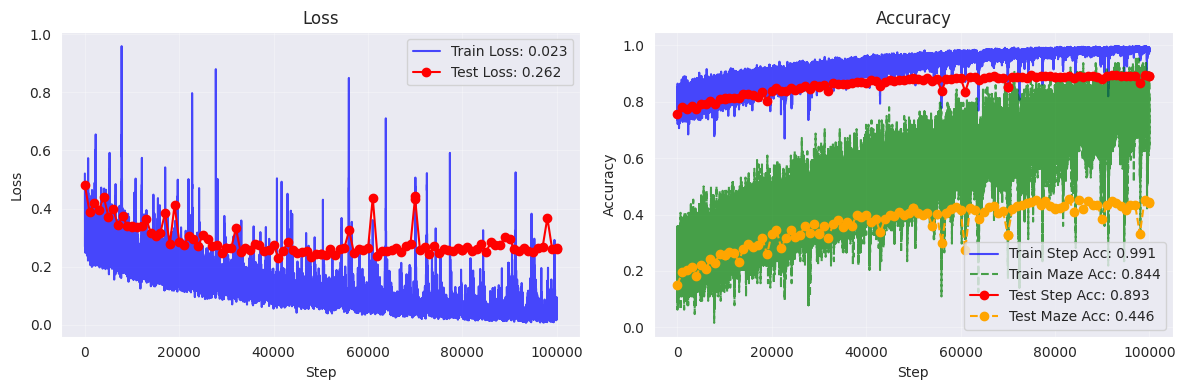

Train Loss=0.023. Train Step Acc=0.991. Train Maze Acc=0.844. Test Loss=0.262. Test Step Acc=0.893. Test Maze Acc=0.446. LR=0.000100. Where_certain=33.97+-11.55 (9<->49). Upto=53.81.: 100%|██████████| 100001/100001 [00:23<00:00, 23.54s/it]


In [18]:
model = train(model=model, trainloader=trainloader, testloader=testloader, device=device, training_iterations=100001, test_every=1000, checkpoint_every=10000, lr=1e-4, log_dir='./maze_logs')

In [21]:
from IPython.display import Image, display

In [41]:
create_maze_gif_visualization(model, testloader, device, "maze_logs")


Plotting neural dynamics: 100%|██████████| 100/100 [00:04<00:00, 27.51it/s]
                                                                           
Processing frames for maze plotting: 100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


Visualise a gif of a solution

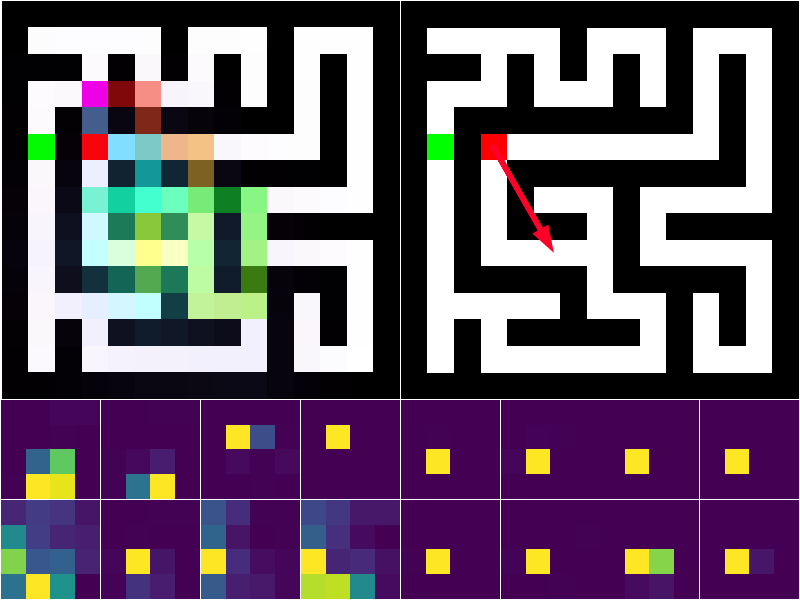

In [42]:
reader = imageio.get_reader("maze_logs/prediction.gif")
frames = [reader.get_data(i) for i in range(min(len(reader), 100))]
display(Image(filename="maze_logs/prediction.gif"))